In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [3]:
def plotOutliers(data, palette="turbo"):
    ax = sns.violinplot(data=data, inner=None, linewidth=0, saturation=0.4)
    sns.boxplot(data=data, palette=palette, width=0.3,
            boxprops={'zorder': 2}, ax=ax)

In [4]:
def highlightOutliers(df, column):
    q75, q25 = np.percentile(df.loc[:, column], [75, 25])  # step 1
    intr_qr = q75 - q25  # step 2

    max = q75 + (1.5 * intr_qr)  # step 3
    min = q25 - (1.5 * intr_qr)  # step 4

    df.loc[df[column] < min, column] = np.nan  # step 5
    df.loc[df[column] > max, column] = np.nan  # step 5

In [5]:
def removeOutliers(df):
    # dropping rows with null values
    return df.dropna(axis=0)

In [6]:
df = pd.read_csv("./dataset.csv")
# extract 'latitude' and 'longitude' columns
X = df.loc[:, ['latitude', 'longitude']]
X.head(5)

,latitude,longitude
0,33.2958,-104.4518
1,41.4898,-120.5516
2,42.8025,-73.9275
3,33.0508,-84.1528
4,41.3837,-89.8383


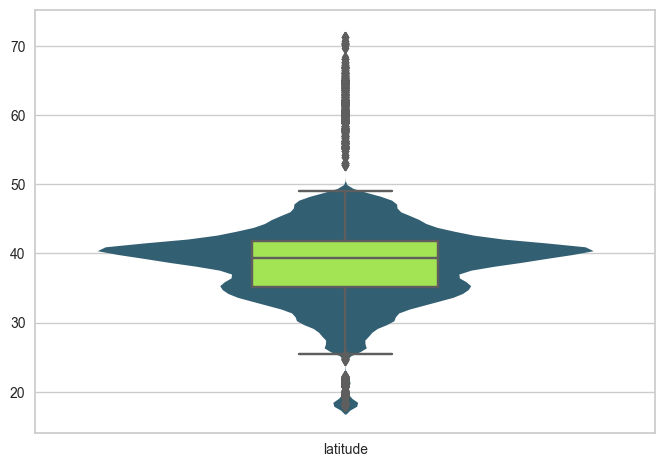

In [7]:
# identifing outliers for latitude
plotOutliers(X[['latitude']])

In [8]:
highlightOutliers(X, 'latitude')
X.isnull().sum()

latitude     2571
longitude       0
dtype: int64

In [9]:
X = removeOutliers(X)
X.isnull().sum()

latitude     0
longitude    0
dtype: int64

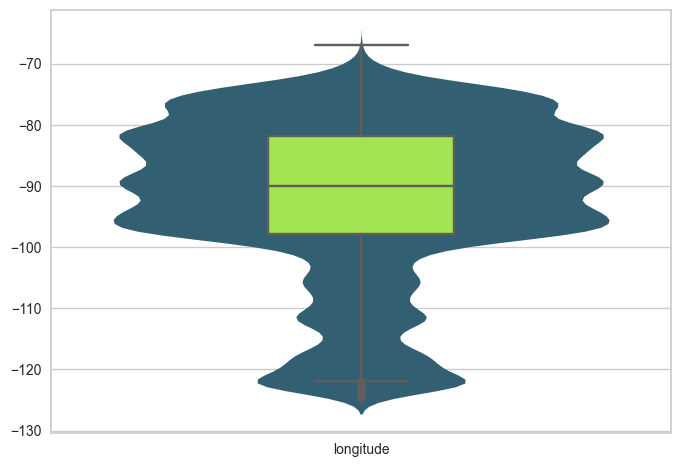

In [10]:
# identifing outliers for longitude
plotOutliers(X[['longitude']])

In [11]:
highlightOutliers(X, 'longitude')
X.isnull().sum()

latitude        0
longitude    3624
dtype: int64

In [12]:
X = removeOutliers(X)
X.isnull().sum()

latitude     0
longitude    0
dtype: int64

Standardize and visualize the data

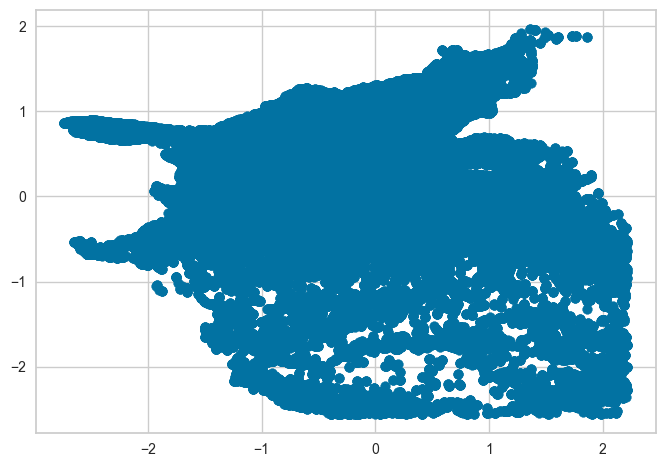

In [13]:
from sklearn.preprocessing import StandardScaler

Y = StandardScaler().fit_transform(X.copy())

plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

We are gonna use the DBScan algorithm to cluster the data. The DBScan algorithm works around three parameters: 
1. eps: Two points are considered neighbors if the distance between the two points is below the threshold epsilon; 
2. minPoints: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples; 
3. metric: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance); 

First thing we are gonna determine what is a good value for eps in order to maximize the effectivness of the clsutering. To find the right value for eps we are going to use the kneed method described in the here: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [14]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

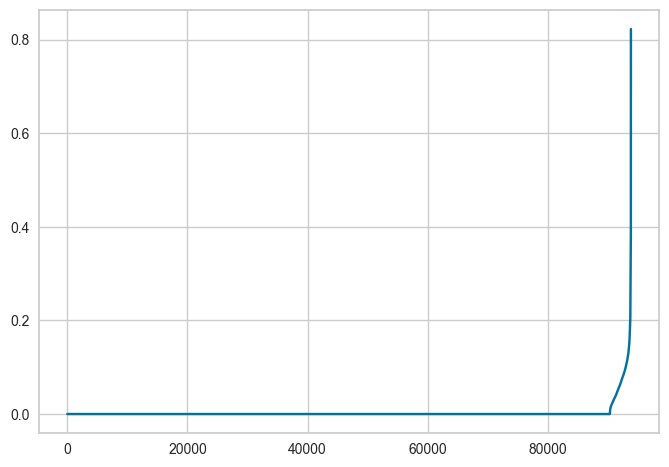

In [15]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

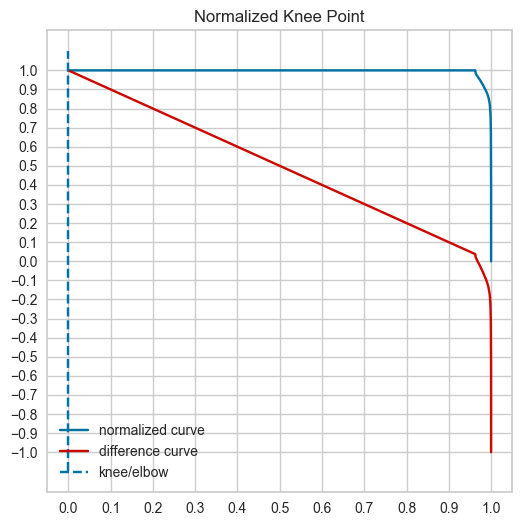

In [16]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(distances)+1),  #x values
                      distances, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()

The optimal value for eps in stored in kneedle.knee_y 

In [17]:
kneedle.knee_y

0.0

Now we should determine the value for the minPoints parameters. Since the dataset X contains only two dimensions (latitude and longitude) the value should be 4 according to this article: https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf?source=post_page . 

In [18]:
model = DBSCAN(eps=kneedle.knee_y + 0.01, min_samples=4)
model.fit(Y)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8184
Estimated number of noise points: 14269


We are going to remove them and retrain the model on the filtered dataset. Noise points are given the label -1.

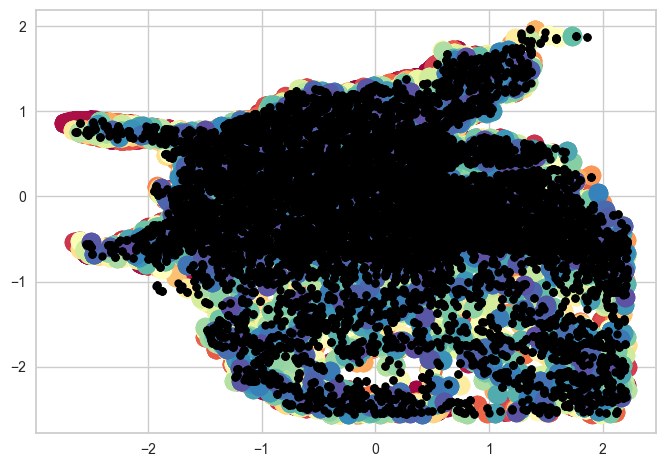

In [19]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Y[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = Y[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.show()

In [20]:
from sklearn.metrics import silhouette_score

print(f"Silhouette Coefficient: {silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.248


Deleting noise points from dataset

In [ ]:
noise_points = np.where(labels == -1)[0]
df_without_noise = df.drop(noise_points)
# df_without_noise.to_csv("./dataset_without_noise.csv", index=False)
df_without_noise.head(10)

Training again the model with the new dataset

In [27]:
X = df_without_noise[['latitude', 'longitude']]
Y = StandardScaler().fit_transform(X.copy())
model = DBSCAN(eps=kneedle.knee_y + 0.01, min_samples=4)
model.fit(Y)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 5856
Estimated number of noise points: 11260


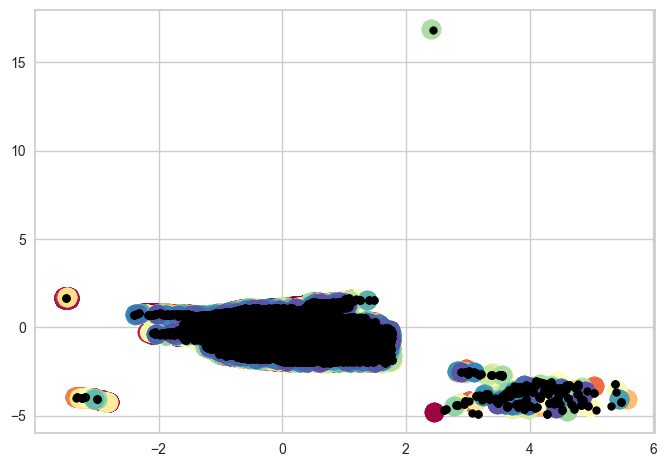

In [28]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Y[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = Y[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.show()

In [29]:
print(f"Silhouette Coefficient: {silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.109
